In [1]:
import pandas as pd
import numpy as np
import torch
from sklearn import preprocessing
dtype = torch.float64
device = torch.device("cuda:0")
torch.manual_seed(42)
data = pd.read_csv("NN_training.nn")
np.random.seed(42)

In [2]:
data = data.set_index("Unnamed: 0")

In [3]:
x = data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
d2 = pd.DataFrame(x_scaled)
train, validate, test = np.split(d2.sample(frac=1), [int(.6*len(d2)), int(.8*len(d2))])

In [4]:
y_tr = torch.from_numpy(train.iloc[:,0].to_numpy())
y_tr = y_tr.view(y_tr.shape[0], 1)
y_te = torch.from_numpy(test.iloc[:,0].to_numpy())
y_te = y_te.view(y_te.shape[0], 1)
y_va = torch.from_numpy(validate.iloc[:,0].to_numpy())
y_va = y_va.view(y_va.shape[0], 1)

In [5]:
x_tr = torch.from_numpy(train.iloc[:,1:].to_numpy())
x_te = torch.from_numpy(test.iloc[:,1:].to_numpy())
x_va = torch.from_numpy(validate.iloc[:,1:].to_numpy())

In [6]:
print(x_tr.shape, y_tr.shape)

torch.Size([5598, 521]) torch.Size([5598, 1])


In [7]:
x_tr = x_tr.float()
y_tr = y_tr.float()

In [8]:
x_tr = x_tr.cuda()
y_tr = y_tr.cuda()

In [9]:
x_te = x_te.float().cuda()
y_te = y_te.float().cuda()

In [10]:
x_va = x_te.float().cuda()
y_va = y_te.float().cuda()

In [11]:
l_rate = 1e-6

input_dim, hiden_dim, h2, h3, h4, h5, h6, h7, output_dim = x_tr.shape[1], 500, 250, 250, 125, 125, 30, 30, y_tr.shape[1]
model = torch.nn.Sequential(
    torch.nn.Linear(input_dim, hiden_dim),
    torch.nn.ReLU(),
    torch.nn.Linear(hiden_dim, h2),
    torch.nn.ReLU(),
    torch.nn.Linear(h2, h3),
    torch.nn.ReLU(),
    torch.nn.Linear(h3, h4),
    torch.nn.ReLU(),
    torch.nn.Linear(h4, h5),
    torch.nn.ReLU(),
    torch.nn.Linear(h5, h6),
    torch.nn.ReLU(),
    torch.nn.Linear(h6, h7),
    torch.nn.ReLU(),
    torch.nn.Linear(h7, output_dim),
)
model.cuda()
loss_fn = torch.nn.MSELoss(reduction="sum")
losses_train = []
losses_test = []
times = []

<AxesSubplot:xlabel='time', ylabel='test_l'>

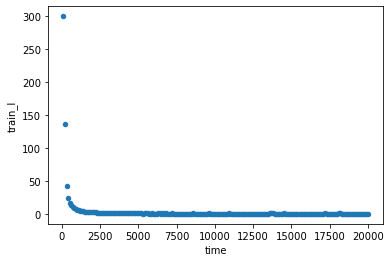

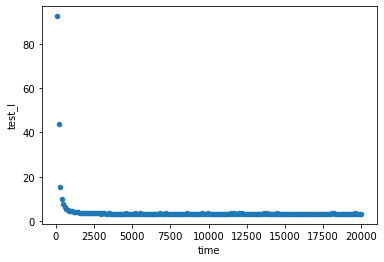

In [12]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
for t in range(20000):
    # Forward pass: compute predicted y by passing x to the model.
    y_pred = model(x_tr)

    # Compute and print loss.
    loss = loss_fn(y_pred, y_tr)
    if t % 100 == 99:
#         print("{:16}{:6}  {:5.3f}".format("training error:", t, loss.item()))
        y_test = model(x_te)
        loss_te = loss_fn(y_test, y_te)
#         print("{:16}{:6}  {:5.3f}".format("test error:", t, loss_te.item()))
        losses_train.append(loss.item())
        losses_test.append(loss_te.item())
        times.append(t)

    # Before the backward pass, use the optimizer object to zero all of the
    # gradients for the variables it will update (which are the learnable
    # weights of the model). This is because by default, gradients are
    # accumulated in buffers( i.e, not overwritten) whenever .backward()
    # is called. Checkout docs of torch.autograd.backward for more details.
    optimizer.zero_grad()

    # Backward pass: compute gradient of the loss with respect to model
    # parameters
    loss.backward()

    # Calling the step function on an Optimizer makes an update to its
    # parameters
    optimizer.step()
stats = pd.DataFrame({"train_l":losses_train, "test_l":losses_test, "time":times})
# stats.plot(x="time", y=["train_l", "test_l"], kind="scatter")
stats.plot(x="time", y="train_l", kind="scatter")
stats.plot(x="time", y="test_l", kind="scatter")

<AxesSubplot:xlabel='time', ylabel='test_l'>

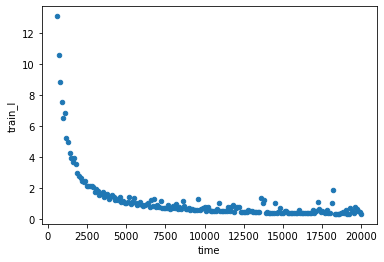

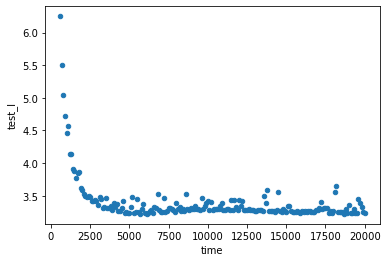

In [13]:
stats.iloc[5:,:].plot(x="time", y="train_l", kind="scatter")
stats.iloc[5:,:].plot(x="time", y="test_l", kind="scatter")

<AxesSubplot:xlabel='time', ylabel='test_l'>

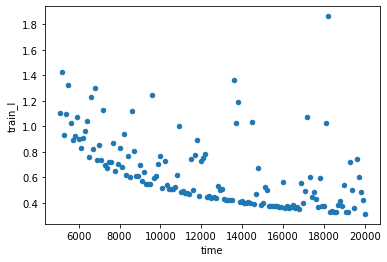

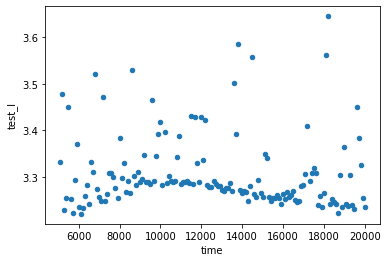

In [14]:
stats.iloc[50:,:].plot(x="time", y="train_l", kind="scatter")
stats.iloc[50:,:].plot(x="time", y="test_l", kind="scatter")

In [15]:
y_vali = model(x_va)
loss_va = loss_fn(y_vali, y_va)
print(loss_va.item(), loss_te.item(), loss.item())

3.2322497367858887 3.2357451915740967 0.3119626045227051


In [16]:
from ray import tune

In [17]:
# l_rate = 1e-5

In [18]:

# for t in range(500):
# #     y_pred = model(xc).to(device)
#     y_pred = model(x_tr)
    
# #     y_c_pred = y_pred.to(dev)
#     loss = loss_fn(y_pred, y_tr)
    
#     if t % 1000 == 99:
#         print("{:16}{:6}   {:5.3}".format("training error:", t, loss.item()))
#         y_test = model(x_te)
#         loss_te = loss_fn(y_test, y_te)
#         print("{:16}{:6}  {:5.3}".format("test error:", t, loss_te.item()))
#     if t % 100 == 1:
# #         print("training error:", t, loss.item())
#         y_test = model(x_te)
#         loss_te = loss_fn(y_test, y_te)
# #         print("test error:", t, loss_te.item())
#         losses_train.append(loss.item())
#         losses_test.append(loss_te.item())
#         times.append(t)
#     model.zero_grad()
#     loss.backward()
#     with torch.no_grad():
#         for param in model.parameters():
#             param -= l_rate * param.grad

In [19]:
# stats = pd.DataFrame({"train_l":losses_train, "test_l":losses_test, "time":times})
# # stats.plot(x="time", y=["train_l", "test_l"], kind="scatter")
# stats.plot(x="time", y="train_l", kind="scatter")
# stats.plot(x="time", y="test_l", kind="scatter")

to do:
    Randomize the order of the input data
    training/test set split
    optimise architecture
    test by plotting predicted speeds of other runs
    investigate 1d convolution layer
    print the validation set score with loss
    
    Build alternate model using raw acceleration data (down sample data) - investigate embedding/embedding layer

In [20]:
# checkpoint = {'input_size': xc.shape[1],
#               'output_size': yc.shape[1],
#               "model_dets": model,
#               'state_dict': model.state_dict()}

# torch.save(checkpoint, 'checkpoint.pth')

In [21]:
model

Sequential(
  (0): Linear(in_features=521, out_features=500, bias=True)
  (1): ReLU()
  (2): Linear(in_features=500, out_features=250, bias=True)
  (3): ReLU()
  (4): Linear(in_features=250, out_features=250, bias=True)
  (5): ReLU()
  (6): Linear(in_features=250, out_features=125, bias=True)
  (7): ReLU()
  (8): Linear(in_features=125, out_features=125, bias=True)
  (9): ReLU()
  (10): Linear(in_features=125, out_features=30, bias=True)
  (11): ReLU()
  (12): Linear(in_features=30, out_features=30, bias=True)
  (13): ReLU()
  (14): Linear(in_features=30, out_features=1, bias=True)
)